In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/novozyme/sample_submission.csv
/kaggle/input/novozyme/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozyme/train.csv
/kaggle/input/novozyme/test.csv
/kaggle/input/novozyme/train_updates_20220929.csv


In [3]:
!pip install biopandas
from biopandas.pdb import PandasPdb

pl1 = PandasPdb().read_pdb('/kaggle/input/novozyme/wildtype_structure_prediction_af2.pdb')
pl1.df

ERROR: Could not find a version that satisfies the requirement biopandas (from versions: none)
ERROR: No matching distribution found for biopandas


ModuleNotFoundError: No module named 'biopandas'

**Downloading data**

In [6]:
# df_train = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/train.csv", index_col='seq_id')
# df_test = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/test.csv", index_col='seq_id')
# df_train_up = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv", index_col='seq_id')

df_train = pd.read_csv("/kaggle/input/novozyme/train.csv")
df_test = pd.read_csv("/kaggle/input/novozyme/test.csv")
df_train_up = pd.read_csv("/kaggle/input/novozyme/train_updates_20220929.csv")

**Necessary steps to use TPU**

In [7]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-12-17 14:48:57.106893: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-17 14:48:57.110602: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-17 14:48:57.110652: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-17 14:48:57.110682: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (279486bd0a81): /proc/driver/nvidia/version does not exist
2022-12-17 14:48:57.114376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


**Fixing our dateset**

In [8]:
drop_seq_ids = df_train_up[df_train_up.isnull().sum(axis=1)==4]['seq_id']
df_train = df_train[~df_train.seq_id.isin(drop_seq_ids)]
replace_seq_ids = df_train_up.loc[df_train_up.isnull().sum(axis=1)!=4,"seq_id"]
df_train = df_train[~df_train.seq_id.isin(replace_seq_ids)]
correct_df = df_train_up[df_train_up.isnull().sum(axis=1)!=4]
df_train = pd.concat([df_train, correct_df], ignore_index=True)

In [9]:
df_train

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
28976,1122,DVSGTVCLSALPPEAVDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
28977,1125,DVSGVVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
28978,13447,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,2.7,NaN,64.9
28979,13449,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,2.7,NaN,64.9


In [10]:
df_train1 = df_train.copy()
df_train1.protein_sequence = df_train1.protein_sequence.apply(lambda x: x[::-1])
df_train = pd.concat([df_train, df_train1])

In [11]:
df_train = df_train.drop('data_source', axis=1)
df_test = df_test.drop('data_source', axis=1)

In [12]:
df_train

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...,...
28976,1122,CTQDILSFTAYHDGTYYDEQTAEGTIIRRTGRTRAGPTIVTYEHYY...,7.0,48.4
28977,1125,CTQDILSFTAYHDGTYYDEQTAEGTIIRRTGRTRAGPTIVTYEHYY...,7.0,48.4
28978,13447,VGCGQVYQRVDRAQCRNRWAVWARIGQPDRVVRKACAVADAINDQL...,2.7,64.9
28979,13449,VGCGQVYQRVDRGQCRNRWAVWARIGQPDRVVRKACAVADAINDQL...,2.7,64.9


In [13]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

X=df_train.copy()
X=X.dropna()
X['len']=X['protein_sequence'].str.len()
X=X.query('0<=pH<=14')
X['M_weight']=X['protein_sequence'].apply(lambda r :  ProteinAnalysis(r).molecular_weight())
df_train = X

X=df_test.copy()
X=X.dropna()
X['len']=X['protein_sequence'].str.len()
X=X.query('0<=pH<=14')
X['M_weight']=X['protein_sequence'].apply(lambda r :  ProteinAnalysis(r).molecular_weight())
df_test = X

In [14]:
char_seq = {'A': 0}

max_seq = 0

def get_char_index(c):
    
    if c in char_seq.keys():
        return char_seq[c]
    else:
        char_seq[c] = len(char_seq)
    
    return len(char_seq)
        
    
def to_seq(string):
    
    new_seq = [get_char_index(c) for c in string]
    
    return new_seq

def get_counts(seq):
    
    counts = np.zeros(len(char_seq) + 1)
    
    for i, c in enumerate(char_seq.keys()):
        counts[i] = sum([x == c for x in seq]) / len(seq)
        
    counts[len(char_seq)] = len(seq) / 1_000
        
    return counts

def create_features(df):
    
    df['seq'] = df['protein_sequence'].apply(to_seq)
    
    df['counts'] = df['protein_sequence'].apply(get_counts)
        
    print(len(char_seq))

    return df

In [15]:
df_train = create_features(df_train)
df_test = create_features(df_test)

20
20


In [16]:
y_train = df_train['tm'].values

df_train = df_train.drop(['protein_sequence', 'tm'], axis=1)
df_test = df_test.drop('protein_sequence', axis=1)

In [17]:
df_train

,seq_id,pH,len,M_weight,seq,counts
0,0,7.0,341,36320.7244,"[0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 2, 2, 4, 5, 0, ...","[0.13196480938416422, 0.0469208211143695, 0.10..."
1,1,7.0,286,32837.9931,"[0, 0, 0, 7, 3, 4, 5, 2, 15, 17, 4, 4, 4, 10, ...","[0.0979020979020979, 0.06643356643356643, 0.08..."
2,2,7.0,497,53428.8034,"[0, 0, 0, 12, 16, 14, 5, 10, 0, 14, 16, 18, 10...","[0.1006036217303823, 0.07847082494969819, 0.03..."
3,3,7.0,265,29475.5996,"[0, 0, 0, 16, 3, 2, 10, 14, 0, 8, 5, 0, 11, 5,...","[0.07547169811320754, 0.06415094339622641, 0.1..."
4,4,7.0,1451,158761.9814,"[0, 0, 0, 14, 1, 16, 3, 5, 10, 10, 11, 16, 11,...","[0.059269469331495524, 0.04686423156443832, 0...."
...,...,...,...,...,...,...
28976,1122,7.0,96,10573.4557,"[19, 14, 11, 7, 8, 2, 16, 12, 14, 0, 18, 15, 7...","[0.0625, 0.0, 0.0625, 0.08333333333333333, 0.0..."
28977,1125,7.0,96,10573.4557,"[19, 14, 11, 7, 8, 2, 16, 12, 14, 0, 18, 15, 7...","[0.0625, 0.0, 0.0625, 0.08333333333333333, 0.0..."
28978,13447,2.7,148,16493.8303,"[6, 3, 19, 3, 11, 6, 18, 11, 10, 6, 7, 10, 0, ...","[0.10810810810810811, 0.04054054054054054, 0.0..."
28979,13449,2.7,148,16479.8037,"[6, 3, 19, 3, 11, 6, 18, 11, 10, 6, 7, 10, 3, ...","[0.10135135135135136, 0.04054054054054054, 0.0..."


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train[['pH', 'len', 'M_weight']] = scaler.fit_transform(df_train[['pH', 'len', 'M_weight']])
df_test[['pH', 'len', 'M_weight']] = scaler.transform(df_test[['pH', 'len', 'M_weight']])


In [19]:
df_train.head()

,seq_id,pH,len,M_weight,seq,counts
0,0,0.160789,-0.265613,-0.302593,"[0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 2, 2, 4, 5, 0, ...","[0.13196480938416422, 0.0469208211143695, 0.10..."
1,1,0.160789,-0.397545,-0.377409,"[0, 0, 0, 7, 3, 4, 5, 2, 15, 17, 4, 4, 4, 10, ...","[0.0979020979020979, 0.06643356643356643, 0.08..."
2,2,0.160789,0.108593,0.064923,"[0, 0, 0, 12, 16, 14, 5, 10, 0, 14, 16, 18, 10...","[0.1006036217303823, 0.07847082494969819, 0.03..."
3,3,0.160789,-0.447919,-0.449640,"[0, 0, 0, 16, 3, 2, 10, 14, 0, 8, 5, 0, 11, 5,...","[0.07547169811320754, 0.06415094339622641, 0.1..."
4,4,0.160789,2.397007,2.327690,"[0, 0, 0, 14, 1, 16, 3, 5, 10, 10, 11, 16, 11,...","[0.059269469331495524, 0.04686423156443832, 0...."


In [20]:
df_test.head()

,seq_id,pH,len,M_weight,seq,counts
0,31390,1.421552,-0.553464,-0.569195,"[6, 5, 6, 17, 5, 4, 5, 7, 0, 14, 16, 6, 4, 17,...","[0.09954751131221719, 0.1085972850678733, 0.04..."
1,31391,1.421552,-0.553464,-0.569215,"[6, 5, 6, 17, 5, 4, 5, 7, 0, 14, 16, 6, 4, 17,...","[0.09954751131221719, 0.11312217194570136, 0.0..."
2,31392,1.421552,-0.555863,-0.571968,"[6, 5, 6, 17, 5, 4, 5, 7, 0, 14, 16, 6, 4, 17,...","[0.1, 0.10909090909090909, 0.04545454545454545..."
3,31393,1.421552,-0.553464,-0.570075,"[6, 5, 6, 17, 5, 4, 5, 7, 0, 14, 16, 6, 4, 17,...","[0.09954751131221719, 0.10407239819004525, 0.0..."
4,31394,1.421552,-0.553464,-0.569129,"[6, 5, 6, 17, 5, 4, 5, 7, 0, 14, 16, 6, 4, 17,...","[0.09954751131221719, 0.10407239819004525, 0.0..."


In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(df_train[['pH', 'len', 'M_weight']])
train_gr = kmeans.predict(df_train[['pH', 'len', 'M_weight']])
test_gr = kmeans.predict(df_test[['pH', 'len', 'M_weight']])

In [22]:
from tensorflow.keras.preprocessing import sequence
max_words = 1_000

X_train = sequence.pad_sequences(df_train['seq'].values, maxlen=max_words)
X_test = sequence.pad_sequences(df_test['seq'].values, maxlen=max_words)

X_train = np.concatenate([X_train, df_train['pH'].fillna(7.0).values.reshape((-1, 1))], axis = 1)
X_test = np.concatenate([X_test, df_test['pH'].fillna(7.0).values.reshape((-1, 1))], axis = 1)

X_train = np.concatenate([X_train, df_train['len'].values.reshape((-1, 1))], axis = 1)
X_test = np.concatenate([X_test, df_test['len'].values.reshape((-1, 1))], axis = 1)

X_train = np.concatenate([X_train, df_train['M_weight'].values.reshape((-1, 1))], axis = 1)
X_test = np.concatenate([X_test, df_test['M_weight'].values.reshape((-1, 1))], axis = 1)

X_train = np.concatenate([X_train, np.array(list(df_train['counts'].values))], axis = 1)
X_test = np.concatenate([X_test, np.array(list(x for x in df_test['counts'].values))], axis = 1)

# y_train = df_train['tm'].values

In [23]:
X_valid_ = X_train[train_gr==test_gr.mean()]
y_valid_ = y_train[train_gr==test_gr.mean()]

X_train2_ = X_train[train_gr!=test_gr.mean()]
y_train2_ = y_train[train_gr!=test_gr.mean()]

In [24]:
test_gr.mean()
X_train[train_gr==test_gr.mean()].shape

(1210, 1024)

In [25]:
df_train

,seq_id,pH,len,M_weight,seq,counts
0,0,0.160789,-0.265613,-0.302593,"[0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 2, 2, 4, 5, 0, ...","[0.13196480938416422, 0.0469208211143695, 0.10..."
1,1,0.160789,-0.397545,-0.377409,"[0, 0, 0, 7, 3, 4, 5, 2, 15, 17, 4, 4, 4, 10, ...","[0.0979020979020979, 0.06643356643356643, 0.08..."
2,2,0.160789,0.108593,0.064923,"[0, 0, 0, 12, 16, 14, 5, 10, 0, 14, 16, 18, 10...","[0.1006036217303823, 0.07847082494969819, 0.03..."
3,3,0.160789,-0.447919,-0.449640,"[0, 0, 0, 16, 3, 2, 10, 14, 0, 8, 5, 0, 11, 5,...","[0.07547169811320754, 0.06415094339622641, 0.1..."
4,4,0.160789,2.397007,2.327690,"[0, 0, 0, 14, 1, 16, 3, 5, 10, 10, 11, 16, 11,...","[0.059269469331495524, 0.04686423156443832, 0...."
...,...,...,...,...,...,...
28976,1122,0.160789,-0.853309,-0.855696,"[19, 14, 11, 7, 8, 2, 16, 12, 14, 0, 18, 15, 7...","[0.0625, 0.0, 0.0625, 0.08333333333333333, 0.0..."
28977,1125,0.160789,-0.853309,-0.855696,"[19, 14, 11, 7, 8, 2, 16, 12, 14, 0, 18, 15, 7...","[0.0625, 0.0, 0.0625, 0.08333333333333333, 0.0..."
28978,13447,-5.260494,-0.728573,-0.728514,"[6, 3, 19, 3, 11, 6, 18, 11, 10, 6, 7, 10, 0, ...","[0.10810810810810811, 0.04054054054054054, 0.0..."
28979,13449,-5.260494,-0.728573,-0.728816,"[6, 3, 19, 3, 11, 6, 18, 11, 10, 6, 7, 10, 3, ...","[0.10135135135135136, 0.04054054054054054, 0.0..."


...added learning rate exponential decay and some network changes 

... and necessary thing for TPU using ('with strategy.scope()')!

... and Dropout for regularization

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Lambda, \
                         Concatenate, Add, Bidirectional, BatchNormalization, LeakyReLU

with strategy.scope():
    embedding_size = len(char_seq) + 1

    input_ = Input(shape = max_words + embedding_size + 3)
    seq = Lambda(lambda x: x[:,:max_words])(input_)
    par = Lambda(lambda x: x[:,max_words:max_words+3])(input_)
    cts = Lambda(lambda x: x[:,max_words:])(input_)
    # ph1 = BatchNormalization(axis=-1)(ph)
    ph2 = Dense(64)(cts)
    lr1 = LeakyReLU()(ph2)
    dp1 = Dropout(0.1)(lr1)
    # ph20 = BatchNormalization()(ph2)
    ph3 = Dense(64)(dp1)
    lr2 = LeakyReLU()(ph3)
    dp2 = Dropout(0.1)(lr2)
    
    ph4 = Dense(64)(dp2)
    lr3 = LeakyReLU()(ph4)
    dp3 = Dropout(0.1)(lr3)

    emb = Embedding(embedding_size, 16, input_length=max_words)(seq)
    lstm = LSTM(64, activation='tanh', return_sequences=True)(emb)
    lstm1 = LSTM(64, activation='tanh', return_sequences=True)(lstm)
    lstm2 = LSTM(64, activation='tanh')(lstm1)

    concat = Concatenate()([lstm2, dp3, par])

    d1 = Dense(128)(concat)
    lr4 = LeakyReLU()(d1)
    dp4 = Dropout(0.2)(lr4)
    # d10 = BatchNormalization()(d1)
    d2 = Dense(64)(dp4)
    lr5 = LeakyReLU()(d2)
    dp5 = Dropout(0.1)(lr5)
    # d20 = BatchNormalization()(d2)
    d3 = Dense(32)(dp5)
    lr6 = LeakyReLU()(d3)

    concat2 = Concatenate()([lstm2, lr6, par])
    outd = Dense(10, activation='linear')(concat2)
    out= Dense(1,activation ='linear')(outd)
    model = Model(inputs=input_, outputs=out)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=0.001,
                    decay_steps=1000,
                    decay_rate=0.9)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mean_squared_error', 
                  optimizer=opt, 
                  metrics=['RootMeanSquaredError'])


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 24)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1600        lambda_2[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64)           0           dense[0][0]                      
______________________________________________________________________________________________

... and Early stopping

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [28]:
from sklearn.model_selection import train_test_split

# batch_size = 256 * strategy.num_replicas_in_sync
batch_size = 64
num_epochs = 250

X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

history = model.fit(X_train2, y_train2, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    callbacks=[early_stopping])

Epoch 1/250
808/808 [==============================] - 64s 65ms/step - loss: 379.1326 - root_mean_squared_error: 18.1058 - val_loss: 92.8137 - val_root_mean_squared_error: 9.6340
Epoch 2/250
808/808 [==============================] - 48s 59ms/step - loss: 97.0489 - root_mean_squared_error: 9.8510 - val_loss: 89.7778 - val_root_mean_squared_error: 9.4751
Epoch 3/250
808/808 [==============================] - 47s 58ms/step - loss: 86.6081 - root_mean_squared_error: 9.3058 - val_loss: 77.9546 - val_root_mean_squared_error: 8.8292
Epoch 4/250
808/808 [==============================] - 47s 58ms/step - loss: 78.6534 - root_mean_squared_error: 8.8685 - val_loss: 74.4718 - val_root_mean_squared_error: 8.6297
Epoch 5/250
808/808 [==============================] - 47s 58ms/step - loss: 73.7997 - root_mean_squared_error: 8.5903 - val_loss: 73.2428 - val_root_mean_squared_error: 8.5582
Epoch 6/250
808/808 [==============================] - 48s 59ms/step - loss: 73.9977 - root_mean_squared_error: 8

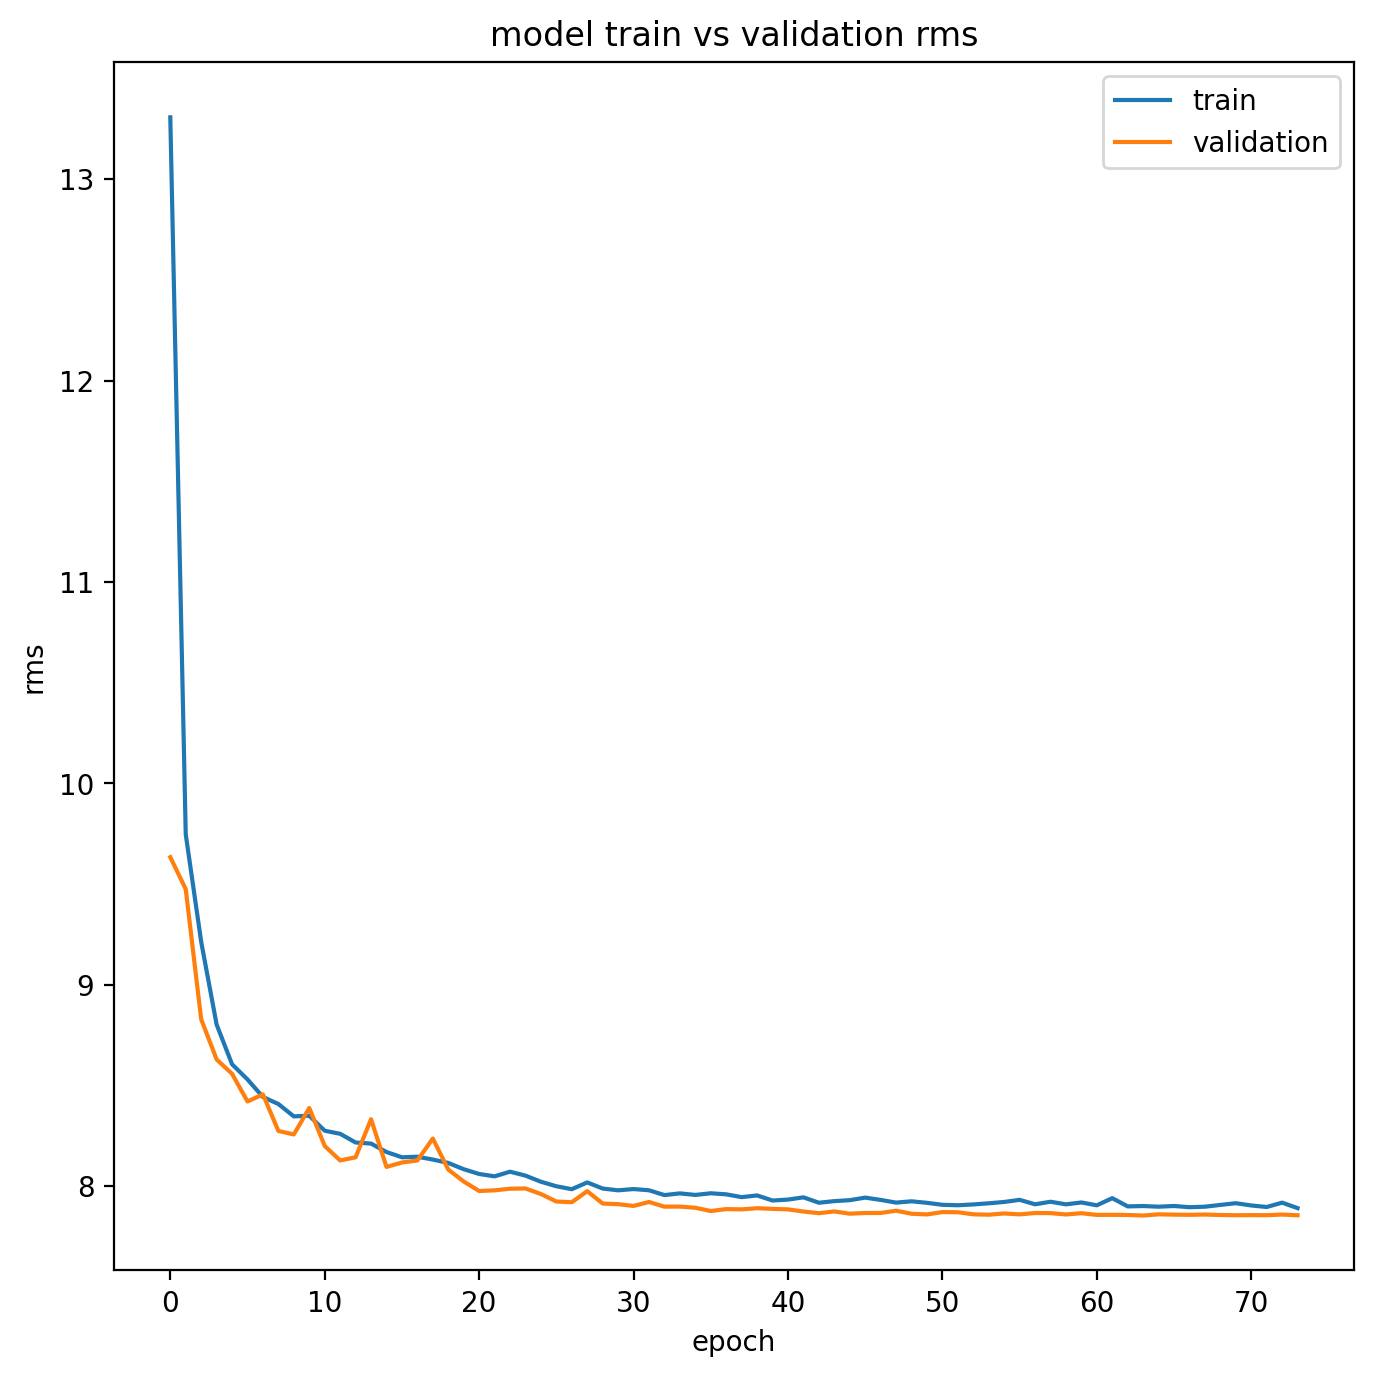

In [29]:
plt.figure(figsize=(8,8),dpi=200)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model train vs validation rms')
plt.ylabel('rms')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

Let's take a look on loss function plots

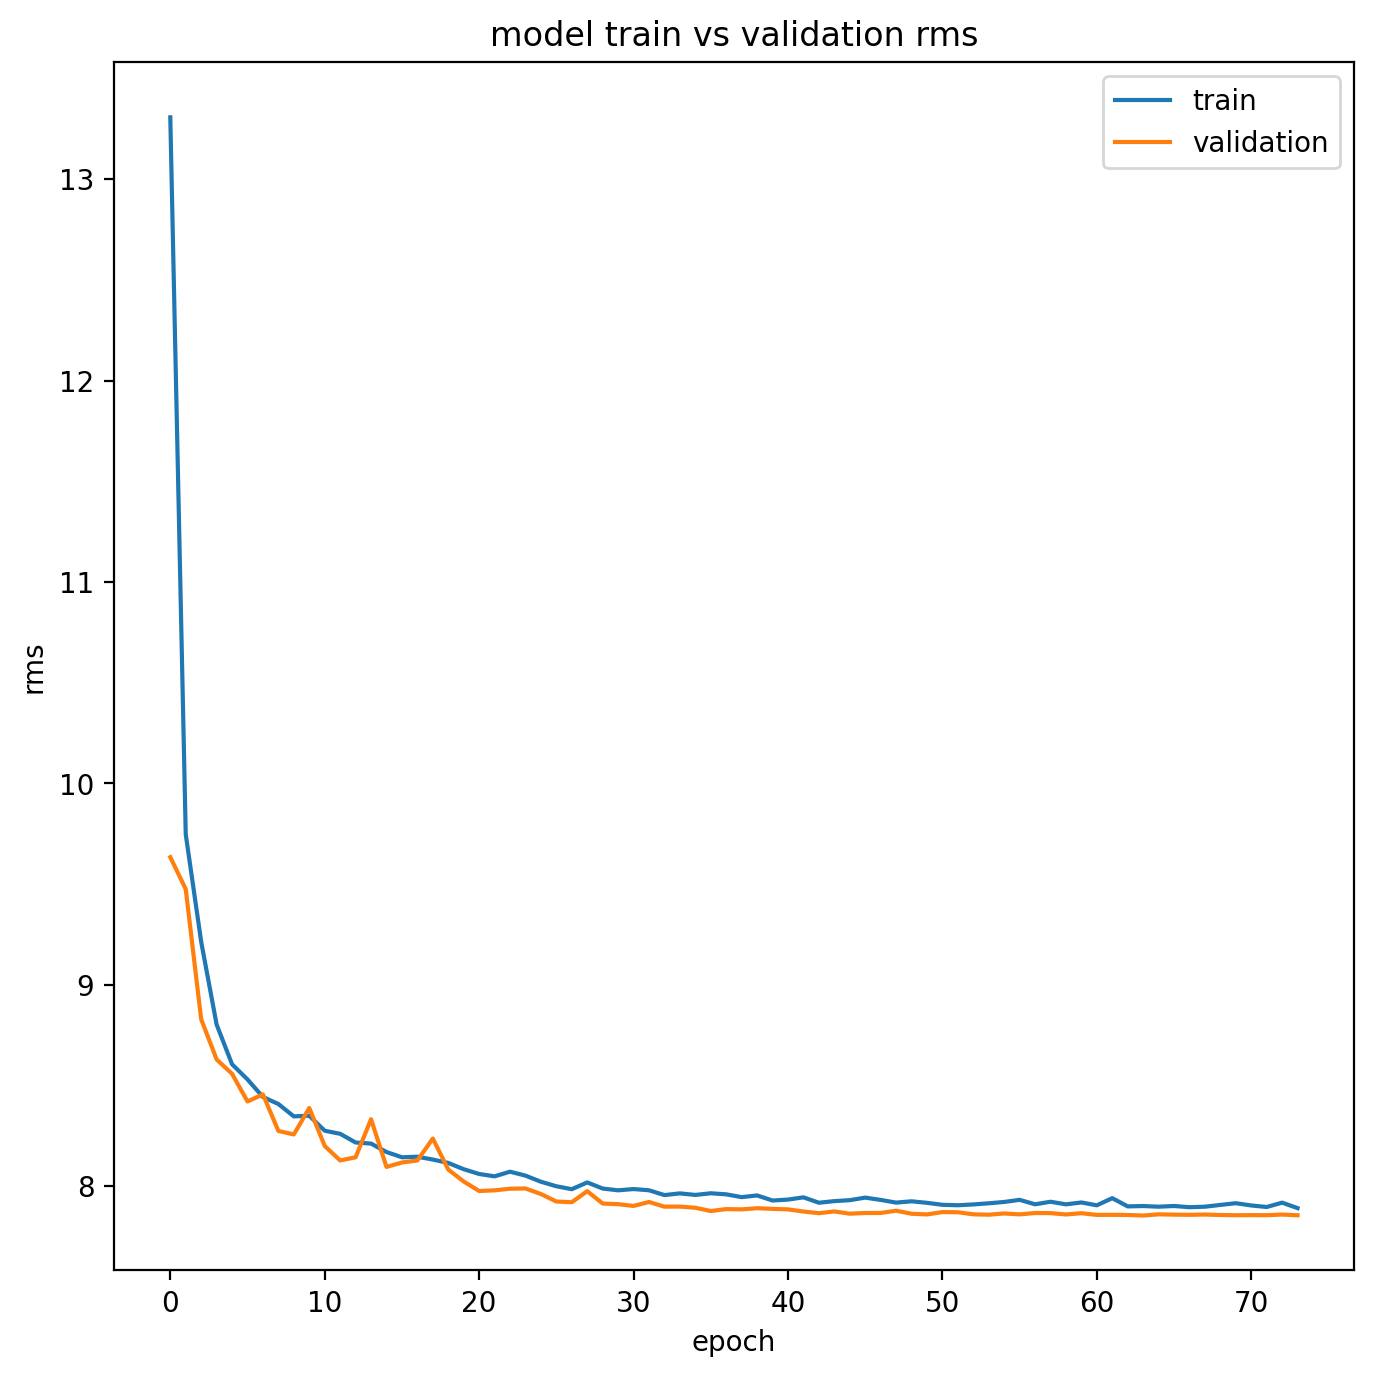

In [30]:
plt.figure(figsize=(8,8),dpi=200)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model train vs validation rms')
plt.ylabel('rms')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

**Making prediction**

In [31]:
y_pred = model.predict(X_test)

In [32]:
model.predict(X_train[:5])

array([[86.8694  ],
       [54.106503],
       [46.78011 ],
       [49.252525],
       [46.731255]], dtype=float32)

In [33]:
test_sub = pd.read_csv('/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv', index_col='seq_id')

In [34]:
test_sub.head()

,tm
seq_id,
31390,0
31391,1
31392,2
31393,3
31394,4


In [35]:
df_test['tm'] = y_pred

In [36]:
df_test.reset_index()[['seq_id','tm']].to_csv('submission.csv', index=False)

In [37]:
df_train['pred'] = model.predict(X_train)
df_train.head()

,seq_id,pH,len,M_weight,seq,counts,pred
0,0,0.160789,-0.265613,-0.302593,"[0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 2, 2, 4, 5, 0, ...","[0.13196480938416422, 0.0469208211143695, 0.10...",86.869400
1,1,0.160789,-0.397545,-0.377409,"[0, 0, 0, 7, 3, 4, 5, 2, 15, 17, 4, 4, 4, 10, ...","[0.0979020979020979, 0.06643356643356643, 0.08...",54.106503
2,2,0.160789,0.108593,0.064923,"[0, 0, 0, 12, 16, 14, 5, 10, 0, 14, 16, 18, 10...","[0.1006036217303823, 0.07847082494969819, 0.03...",46.780109
3,3,0.160789,-0.447919,-0.449640,"[0, 0, 0, 16, 3, 2, 10, 14, 0, 8, 5, 0, 11, 5,...","[0.07547169811320754, 0.06415094339622641, 0.1...",49.252525
4,4,0.160789,2.397007,2.327690,"[0, 0, 0, 14, 1, 16, 3, 5, 10, 10, 11, 16, 11,...","[0.059269469331495524, 0.04686423156443832, 0....",46.731255


Let's compare distributions of our prediction...

<AxesSubplot:ylabel='Frequency'>

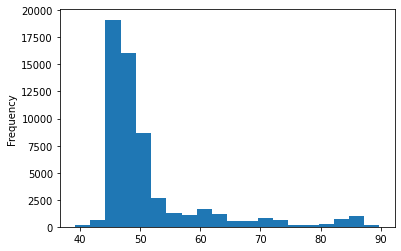

In [38]:
df_train['pred'].plot.hist(bins=20)

... and the whole dataset

<AxesSubplot:ylabel='Frequency'>

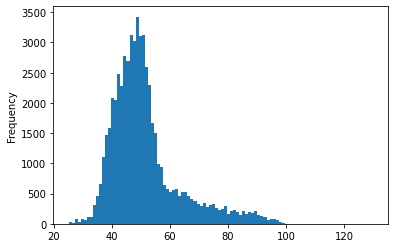

In [39]:
pd.Series(y_train).plot.hist(bins=100)